In [1]:
# - Check if the following properties chnage in each state
    # - Spike Rate
    # - Spike Regularity
    # - Intrinsic Time Constant
    # - Compare by neuron type

In [1]:
from drn_interactions.stats import cv_isi_burst, mannwhitneyu_plusplus
from drn_interactions.load import load_derived_generic, load_neurons_derived
from drn_interactions.spikes import SpikesHandler
from drn_interactions.surrogates import shuffle_spikes
from drn_interactions.brain_state import get_state_piv, get_state_long

from IPython.display import display
import numpy as np
import pandas as pd


def spikerate_change(df_piv):
    return (
        df_piv
        .reset_index()
        .melt(id_vars=["state", "bin"], var_name="neuron_id", value_name="counts")
        .groupby("neuron_id")
        .apply(lambda x: mannwhitneyu_plusplus(x.query("state == 'sw'")["counts"] ,x.query("state == 'act'")["counts"],
        names=["SW", "Act"]))
        .round(3)
    )


In [12]:
from pathlib import Path
from typing import Optional


def get_eeg_sessions(eeg_path: Optional[Path] = None):
    if eeg_path is None:
        eeg_states = load_derived_generic("eeg_states.csv").rename(
            columns={"cluster": "state"}
        )
    else:
        eeg_states = pd.read_csv(eeg_path)
    eeg_states = pd.read_csv(eeg_path)
    neurons = load_neurons_derived()
    return neurons[["session_name"]].drop_duplicates().merge(eeg_states[["session_name"]].drop_duplicates())["session_name"].unique()
    


def load_spikes_states_piv(
    session: str,
    eeg_path: Optional[Path] = None,
    t_start: float =0,
    t_stop: float =1800,
    bin_width: float =1,
    block: str = "pre",
):
    # TODO add option for multiple
    if eeg_path is None:
        eeg_states = load_derived_generic("eeg_states.csv").rename(
            columns={"cluster": "state"}
        )
    else:
        eeg_states = pd.read_csv(eeg_path)
    eeg_states = eeg_states.query(f"session_name == '{session}'")

    sh = SpikesHandler(
        block,
        bin_width=bin_width,
        session_names=[session],
        t_start=t_start,
        t_stop=t_stop,
    )
    spikes = sh.binned_piv
    eeg_states = eeg_states.query(f"session_name == '{session}'")
    spikes = get_state_piv(spikes, eeg)
    eeg_state = spikes.pop("state")
    return spikes, eeg_state  # TODO return one df not two


def load_spikes_states_long(
    session: str,
    eeg_path: Optional[Path] = None,
    t_start: float =0,
    t_stop: float =1800,
    bin_width: float =1,
    block: str = "pre",
):
    spikes = SpikesHandler(
        block,
        bin_width=bin_width,
        session_names=[session],
        t_start=t_start,
        t_stop=t_stop,
    ).binned
    if eeg_path is None:
        eeg_states = load_derived_generic("eeg_states.csv").rename(
            columns={"cluster": "state"}
        )
    else:
        eeg_states = pd.read_csv(eeg_path)
    spikes.merge(eeg_states)

In [22]:
from drn_interactions.brain_state_transforms import BrainStateUtils

In [24]:
eeg_states = load_derived_generic("eeg_states.csv").rename(columns={"cluster": "state"})
spikes = ...
neurons = load_neurons_derived()
sessions = neurons[["session_name"]].drop_duplicates().merge(eeg_states[["session_name"]].drop_duplicates())["session_name"].unique()

In [29]:
sh = SpikesHandler(
    "pre", 
    bin_width=1, 
    session_names=sessions.tolist(),
     t_start=0, 
     t_stop=1800,
    )

transformer = BrainStateUtils()
spikes = sh.binned
spikes = transformer._get_session_name(spikes)

# df = transformer.align_spikes_state_long(sh, eeg_states)

In [31]:
from neurobox.long_transforms import get_closest_event

In [34]:
get_closest_event(
    df_data=spikes, df_events=eeg_states,
    time_after=transformer.eeg_sampling_interval,
    time_before=0,
    df_data_group_colname="session_name",
    df_events_group_colname="session_name",
    df_events_timestamp_col=transformer.eeg_time_col,
    df_data_time_col="bin",
    returned_colname="eeg_bin"
).drop("group", axis=1)

c:\Users\roryl\.conda\envs\drn38\lib\site-packages\neurobox\long_transforms.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[returned_colname] = binit.which_bin(
c:\Users\roryl\.conda\envs\drn38\lib\site-packages\df_grouping_utils\multiple_df_groupby.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_result["group"] = group
c:\Users\roryl\.conda\envs\drn38\lib\site-packages\neurobox\long_transforms.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

,neuron_id,bin,counts,session_name,eeg_bin
8995,9,0,0,ESHOCK_04_LOC1,0.0
8996,9,1,1,ESHOCK_04_LOC1,0.0
8997,9,2,1,ESHOCK_04_LOC1,2.0
8998,9,3,1,ESHOCK_04_LOC1,2.0
8999,9,4,1,ESHOCK_04_LOC1,4.0
...,...,...,...,...,...
366991,2362,1794,3,acute_15,1794.0
366992,2362,1795,5,acute_15,1794.0
366993,2362,1796,6,acute_15,1796.0
366994,2362,1797,2,acute_15,1796.0


In [21]:
sh.binned.merge(load_neurons_derived()[["neuron_id", "session_name"]])

,neuron_id,bin,counts,session_name
0,2592,0,5,acute_11
1,2592,1,6,acute_11
2,2592,2,6,acute_11
3,2592,3,9,acute_11
4,2592,4,11,acute_11
...,...,...,...,...
61161,2634,1794,0,acute_11
61162,2634,1795,0,acute_11
61163,2634,1796,2,acute_11
61164,2634,1797,1,acute_11


In [17]:
load_spikes_states_piv("ESHOCK_08_LOC1", bin_width=1)[1]

bin
0        sw
1        sw
2        sw
3        sw
4        sw
       ... 
1794    act
1795    act
1796    act
1797    act
1798    act
Name: state, Length: 1799, dtype: object

## Load Data

In [8]:
eeg_states = load_derived_generic("eeg_states.csv").rename(columns={"cluster": "state"})
neurons = load_neurons_derived()
sessions = neurons[["session_name"]].drop_duplicates().merge(eeg_states[["session_name"]].drop_duplicates())["session_name"].unique()

In [3]:
t_start=0
t_stop=1800
bin_width=1
spike_window = 120
session = sessions[14]

sh = SpikesHandler(
    "pre", 
    bin_width=bin_width, 
    session_names=[session],
     t_start=t_start, 
     t_stop=t_stop
    )
spikes = sh.binned_piv
eeg = eeg_states.query(f"session_name == '{session}'")
df = get_state_piv(spikes, eeg)

In [13]:
df_res = spikerate_change(df)
df_res.head()

,n_SW,n_Act,Mean_SW,Mean_Act,Diff,U,p
neuron_id,,,,,,,
2592,724.0,1075.0,13.007,5.918,-7.089,94943.0,0.000
2593,724.0,1075.0,14.978,12.493,-2.485,225839.0,0.000
2594,724.0,1075.0,1.707,1.601,-0.106,359771.5,0.003
2595,724.0,1075.0,0.326,1.779,1.453,245445.5,0.000
2596,724.0,1075.0,15.504,15.278,-0.226,370423.5,0.040


<AxesSubplot:>

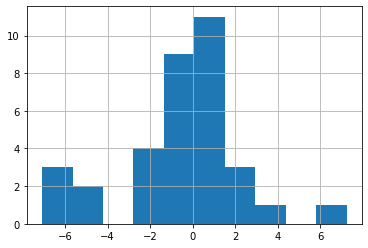

In [14]:
df_res["Diff"].hist()

In [6]:
# CV Change

from drn_interactions.brain_state import most_common_state_in_segment
from drn_interactions.transforms import segment_spikes

def cv_change_segments(df):
    return (
    df
    .groupby(["neuron_id", "segment", "state"])["spiketimes"]
    .apply(cv_isi_burst)
    .to_frame("cv")
    .reset_index()
    .groupby("neuron_id")
    .apply(lambda x: mannwhitneyu_plusplus(x.query("state == 'sw'")["cv"] ,x.query("state == 'act'")["cv"],
        names=["SW", "Act"]))
    .round(3)
    )


In [7]:
segments = np.arange(t_start, t_stop, spike_window)

# sh_surr = shuffle_spikes(sh)
spikes = sh.spikes

eeg = eeg_states.query(f"session_name == '{session}'")
spikes = segment_spikes(spikes, t_start=0, t_stop=1800, segment_length=120)
df = most_common_state_in_segment(spikes, eeg)
df_res = cv_change_segments(df)

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<AxesSubplot:>

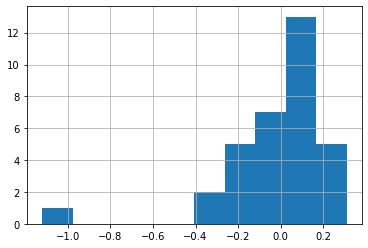

In [8]:
df_res["Diff"].hist()

In [ ]:
# Examples